In [1]:
from scipy.linalg import svd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import dataset using ucimlrepo package

In [61]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 

# data
df = wine_quality.data.original
# df.columns

# red and white wine have different production methods and different chemical qualities (for example, red wines have higher tannins and lower sugar levels)
# thus, we will only be looking at red wine
df_red = df[df["color"] == "white"].copy()

num_whites = (df["color"] == "white").sum()
num_reds = (df["color"] == "red").sum()
print(f"Number of white wines: {num_whites}")
print(f"Number of red wines: {num_reds}")
print("Mean and Median Quality of Red and White Wines:")
print(df_red["quality"].describe())
# print(df_white["quality"].describe())
X = df_red.drop(columns=["quality", "color"])
y = (df_red["quality"] >= 7).astype(int)
distribution = y.value_counts()
print("Distribution of Quality Scores:")
print(distribution)
df = wine_quality.data.original
df.columns

Number of white wines: 4898
Number of red wines: 1599
Mean and Median Quality of Red and White Wines:
count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64
Distribution of Quality Scores:
quality
0    3838
1    1060
Name: count, dtype: int64


Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color'],
      dtype='object')

## Clustering Analysis
We will perform a simple K-Means clustering on the red wine dataset to identify potential groupings based on physicochemical properties. We'll visualize the results using PCA and an interactive 3D plot.


In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Visualize using PCA components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_df = X.copy()
plot_df['Cluster'] = clusters.astype(str)
plot_df['PC1'] = X_pca[:, 0]
plot_df['PC2'] = X_pca[:, 1]
plot_df['PC3'] = X_pca[:, 2]
plot_df['HighQuality'] = (df_red['quality'] >= 7).astype(str)

# Interactive 3D scatter plot
fig = px.scatter_3d(
    plot_df, 
    x='PC1', y='PC2', z='PC3', 
    color='Cluster',
    title='3D PCA Plot of Wine Clusters',
    hover_data=['fixed_acidity', 'alcohol', 'pH'],
    opacity=0.4
)
fig.show()

fig = px.scatter_3d(
    plot_df,
    x='PC1', y='PC2', z='PC3',
    color='HighQuality',
    symbol='Cluster',   # optional: see cluster + quality at once
    opacity=0.5,
    title="High-Quality Wines in PCA Space",
)

fig.show()



## Cluster Analysis Insights
Here we analyze the distribution of wine quality within each cluster and visualize key pairwise relationships.


High Quality (>=7) Wine Distribution per Cluster:
is_high_quality         0         1
Cluster                            
0                0.906770  0.093230
1                0.657652  0.342348
2                0.771954  0.228046

Average Quality Score per Cluster:
Cluster
0    5.607658
1    6.159803
2    5.897209
Name: quality, dtype: float64


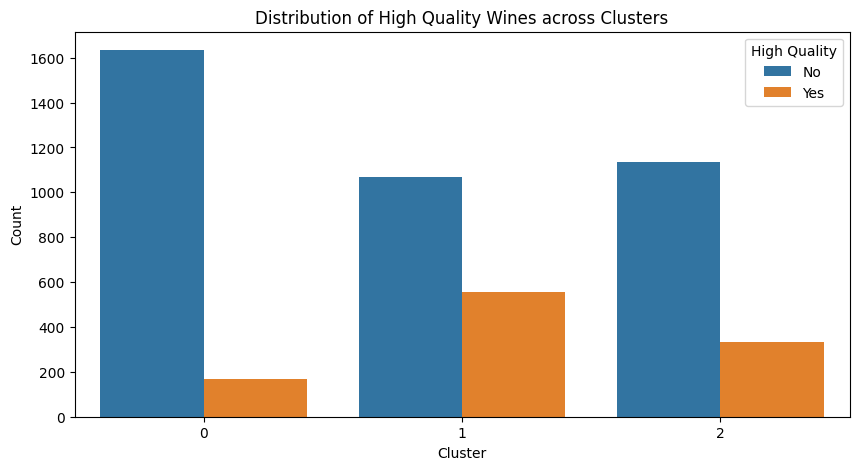

In [55]:
# Add quality information back to the plot dataframe
plot_df['quality'] = df_red['quality'].values
plot_df['is_high_quality'] = (plot_df['quality'] >= 7).astype(int)

# 1. Check class distribution per K-Means cluster
print('High Quality (>=7) Wine Distribution per Cluster:')
print(plot_df.groupby('Cluster')['is_high_quality'].value_counts(normalize=True).unstack())

print('\nAverage Quality Score per Cluster:')
print(plot_df.groupby('Cluster')['quality'].mean())

# Visualize cluster composition
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=plot_df, x='Cluster', hue='is_high_quality')
plt.title('Distribution of High Quality Wines across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='High Quality', labels=['No', 'Yes'])
plt.show()


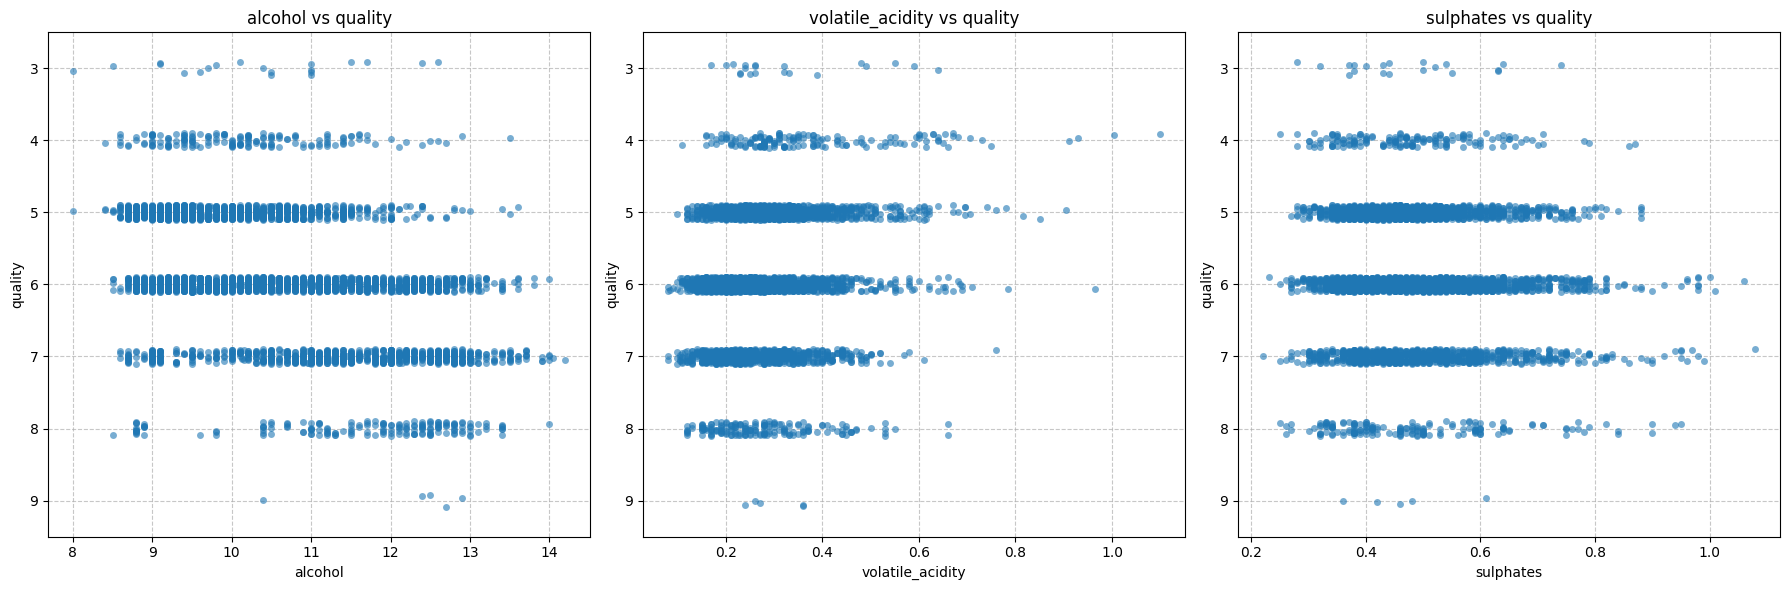

In [56]:
# 2. Visualize pairwise relationships
# Scatterplots of alcohol vs quality, volatile acidity vs quality, sulphates vs quality

features_to_plot = ['alcohol', 'volatile_acidity', 'sulphates']
target = 'quality'

plt.figure(figsize=(18, 6))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i+1)
    # Using jitter to see density better since quality is discrete
    sns.stripplot(data=plot_df, x=feature, y=target, jitter=True, alpha=0.6, orient='h')
    plt.title(f'{feature} vs {target}')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Classification

In [3]:
# split the dataset
# train_test_split can be imported from sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y # random_state ensures random split of data is the same every time so our plots and numbers remain the same
                                                    # stratify ensures the class proportions are preserved in train and test sets which is useful since our dataset
                                                    # is unbalanced (i.e., more low quality (5220 rows) than high quality (1277 rows)
)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train_scaled, y_train)

# predictions
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(test_acc)

0.93125


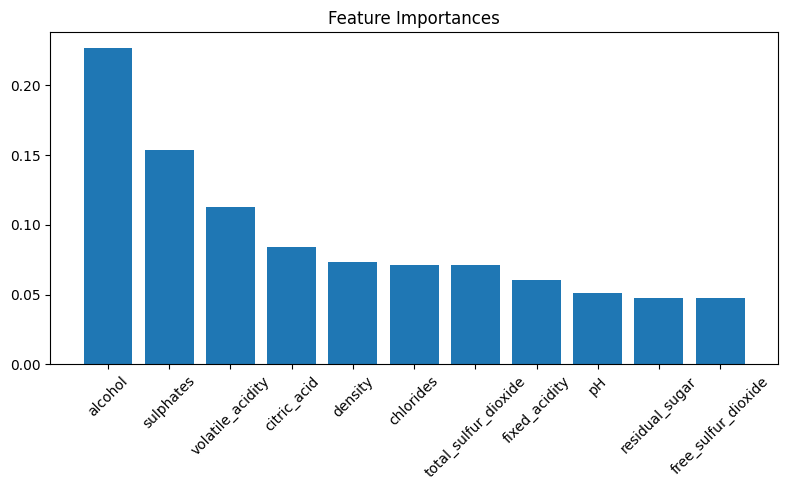

In [4]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), X.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

## Linear Dimension Reduction

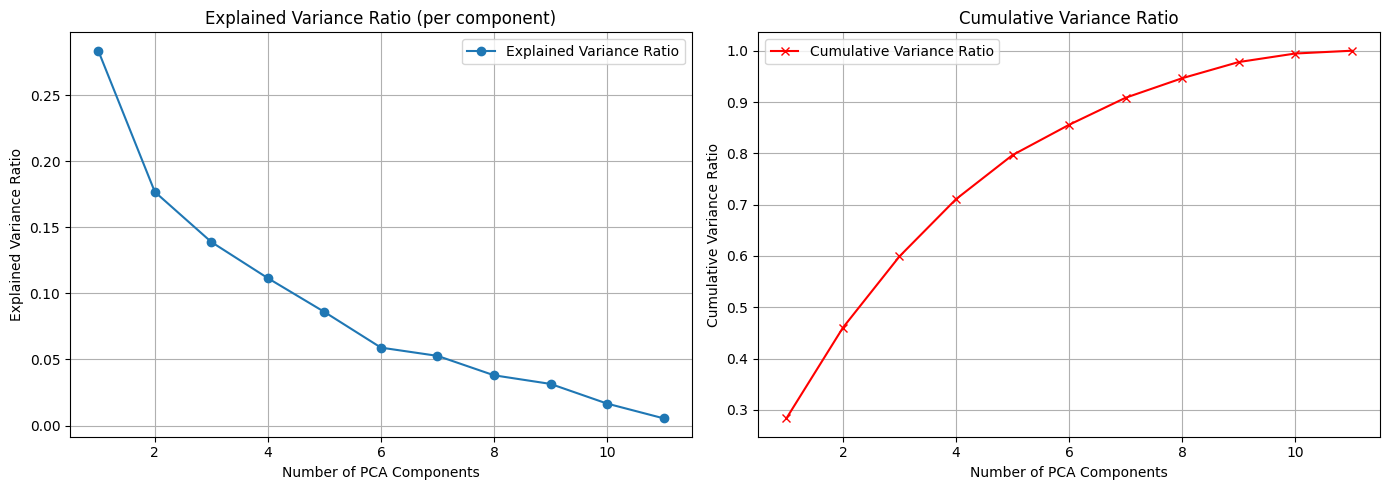

In [5]:
X_train_T = X_train_scaled.T
X_centered = X_train_T - np.mean(X_train_T, axis=1, keepdims=True)

U, s, _ = svd(X_centered, full_matrices=False)

N = X_centered.shape[1]
eigvals = (s**2) / (N - 1)
explained_variance_ratio = eigvals / np.sum(eigvals)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Left plot: Explained Variance Ratio per component
axs[0].plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o',
    label="Explained Variance Ratio"
)
axs[0].set_xlabel("Number of PCA Components")
axs[0].set_ylabel("Explained Variance Ratio")
axs[0].set_title("Explained Variance Ratio (per component)")
axs[0].grid(True)
axs[0].legend()

# Right plot: Cumulative Variance Ratio
axs[1].plot(
    range(1, len(cumulative_variance_ratio) + 1),
    cumulative_variance_ratio,
    color='red',
    marker='x',
    label="Cumulative Variance Ratio"
)
axs[1].set_xlabel("Number of PCA Components")
axs[1].set_ylabel("Cumulative Variance Ratio")
axs[1].set_title("Cumulative Variance Ratio")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

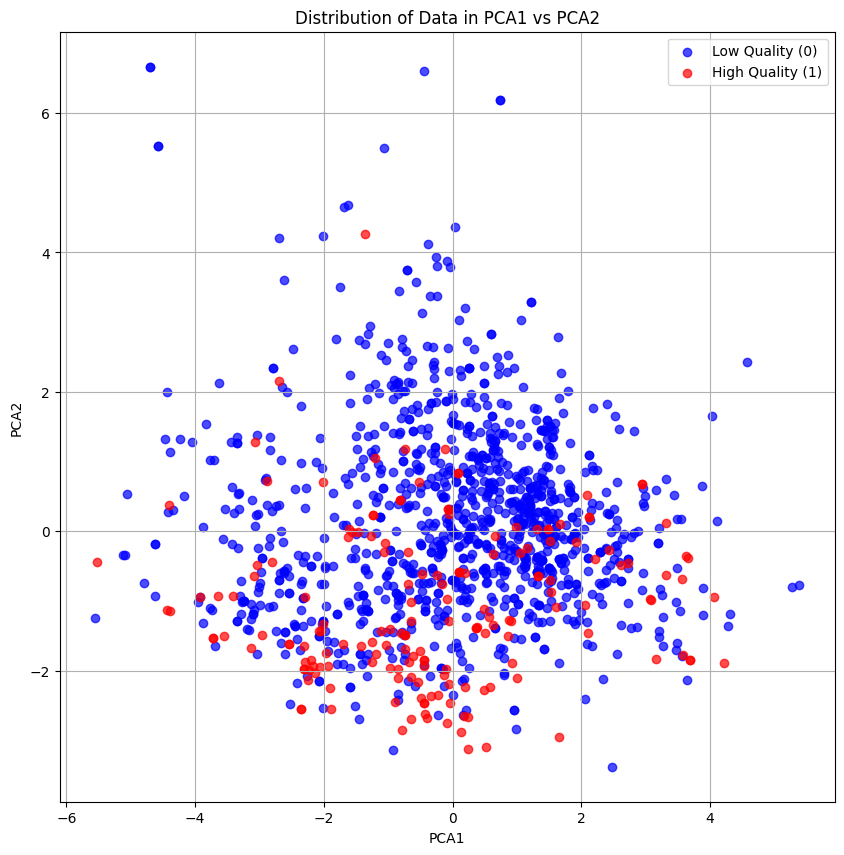

In [6]:
# Project onto first two principal components
PCs = U[:, :2]
Y_train_2D = PCs.T @ X_centered

Y_plot = Y_train_2D.T

plt.figure(figsize=(10,10))
plt.scatter(
    Y_plot[y_train == 0, 0],
    Y_plot[y_train == 0, 1],
    label="Low Quality (0)",
    alpha=0.7,
    color="blue"
)

plt.scatter(
    Y_plot[y_train == 1, 0],
    Y_plot[y_train == 1, 1],
    label="High Quality (1)",
    alpha=0.7,
    color="red"
)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Distribution of Data in PCA1 vs PCA2")
plt.legend()
plt.grid(True)
plt.show()


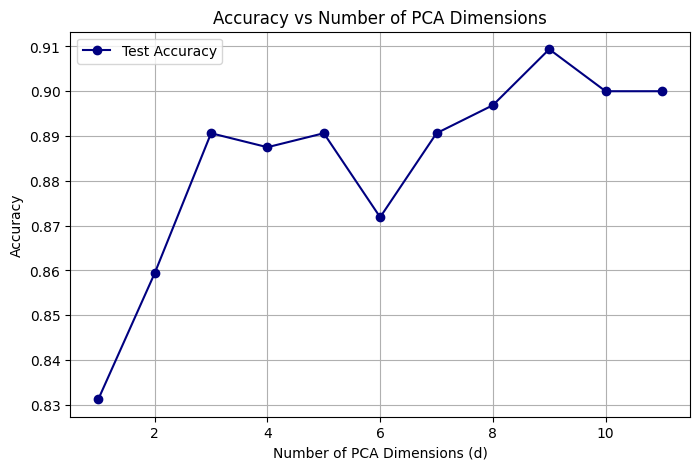

In [7]:
def pca(X, d):
    mu = np.mean(X, axis=1, keepdims=True)
    X_center = X - mu
    U, _, _ = svd(X_center, full_matrices=False)
    Ud = U[:, :d]
    Y = Ud.T @ X_center
    return mu, Ud, Y

def one_nn_accuracy(Y_train, y_train, Y_test, y_test):
    correct = 0
    for i in range(Y_test.shape[1]):
        distances = np.linalg.norm(Y_train - Y_test[:, i][:, None], axis=0)
        nn_idx = np.argmin(distances)
        if y_train[nn_idx] == y_test[i]:
            correct += 1
    return correct / len(y_test)

X_test_T = X_test_scaled.T

dims = range(1, X_train_T.shape[0] + 1)
test_acc = []

for d in dims:
    mu, U, Y_train = pca(X_train_T, d)
    Y_test = U.T @ (X_test_T - mu)
    acc = one_nn_accuracy(Y_train, y_train.values, Y_test, y_test.values)
    test_acc.append(acc)

plt.figure(figsize=(8,5))
plt.plot(dims, test_acc, marker='o', color='navy', label="Test Accuracy")
plt.xlabel("Number of PCA Dimensions (d)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of PCA Dimensions")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
loadings = pd.DataFrame(U, index=X.columns, columns=[f"PC{i+1}" for i in range(U.shape[1])])
print(loadings)

                           PC1       PC2       PC3       PC4       PC5  \
fixed_acidity        -0.488307 -0.105901  0.120398 -0.222136  0.079909   
volatile_acidity      0.238143  0.288636  0.439816  0.101726 -0.203418   
citric_acid          -0.458350 -0.161020 -0.234962 -0.080632  0.064494   
residual_sugar       -0.147672  0.284408 -0.103865 -0.372026 -0.720708   
chlorides            -0.205946  0.141558  0.075296  0.680375 -0.252013   
free_sulfur_dioxide   0.028509  0.514056 -0.427833 -0.054339  0.176175   
total_sulfur_dioxide -0.027687  0.566206 -0.315024 -0.022827  0.250284   
density              -0.401132  0.232105  0.320368 -0.172301 -0.182292   
pH                    0.438540  0.019711 -0.078642 -0.015870 -0.279061   
sulphates            -0.238862 -0.053988 -0.325016  0.527548 -0.229168   
alcohol               0.136671 -0.369596 -0.472932 -0.144128 -0.328395   

                           PC6       PC7       PC8       PC9      PC10  \
fixed_acidity        -0.163137  0.346

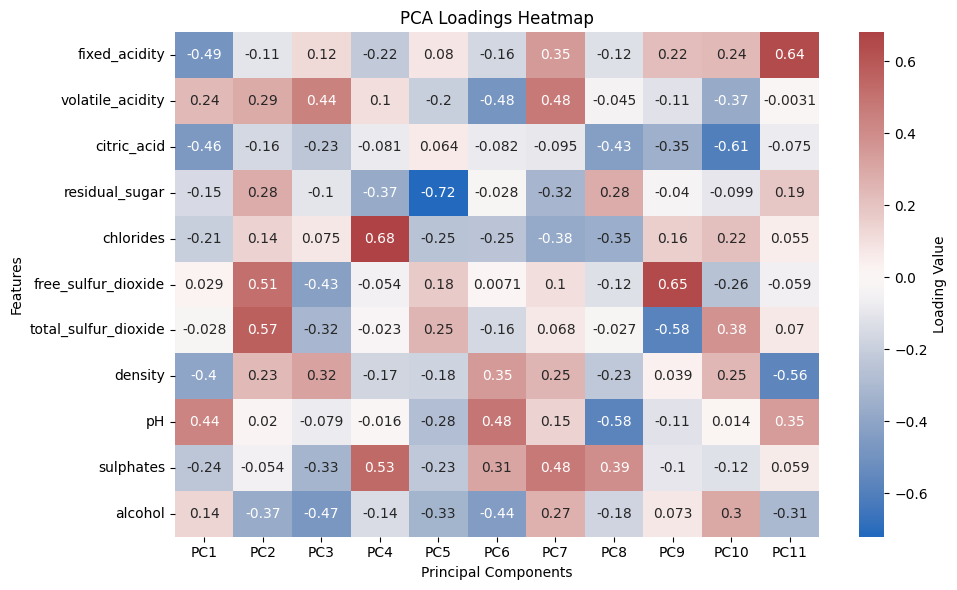

In [9]:
import seaborn as sns

loadings = pd.DataFrame(U, index=X.columns, columns=[f"PC{i+1}" for i in range(U.shape[1])])

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="vlag", center=0, cbar_kws={"label": "Loading Value"})
plt.title("PCA Loadings Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [10]:
# TO-DO: analyze these relationships ^^

## Non-Linear Dimension Reduction (Isomap)

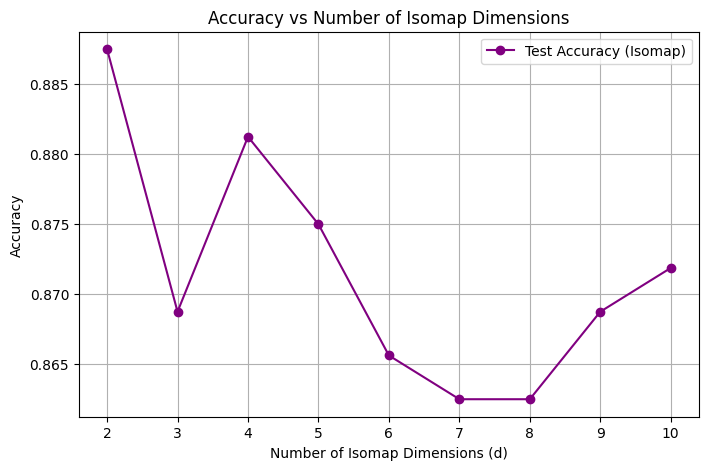

In [11]:
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier

# Define dimensions to test
dims = range(2, 11)
iso_test_acc = []

for d in dims:
    iso = Isomap(n_components=d)
    X_train_iso = iso.fit_transform(X_train_scaled)
    X_test_iso = iso.transform(X_test_scaled)
    
    # Using 1-NN to be comparable with the PCA section
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_iso, y_train)
    acc = knn.score(X_test_iso, y_test)
    iso_test_acc.append(acc)

plt.figure(figsize=(8,5))
plt.plot(dims, iso_test_acc, marker='o', color='purple', label="Test Accuracy (Isomap)")
plt.xlabel("Number of Isomap Dimensions (d)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Isomap Dimensions")
plt.grid(True)
plt.legend()
plt.show()

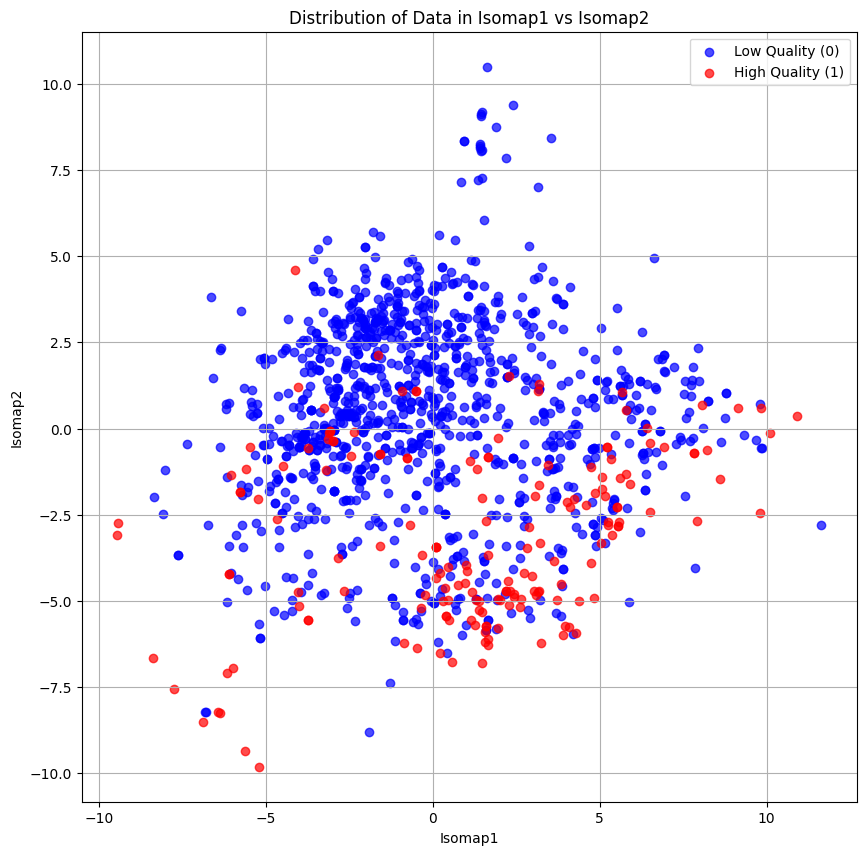

In [12]:
# 2D Isomap Visualization
iso_2d = Isomap(n_components=2)
X_train_iso_2d = iso_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10,10))
plt.scatter(
    X_train_iso_2d[y_train == 0, 0],
    X_train_iso_2d[y_train == 0, 1],
    label="Low Quality (0)",
    alpha=0.7,
    color="blue"
)

plt.scatter(
    X_train_iso_2d[y_train == 1, 0],
    X_train_iso_2d[y_train == 1, 1],
    label="High Quality (1)",
    alpha=0.7,
    color="red"
)

plt.xlabel("Isomap1")
plt.ylabel("Isomap2")
plt.title("Distribution of Data in Isomap1 vs Isomap2")
plt.legend()
plt.grid(True)
plt.show()

### Analysis & Comparison

**Observation:**
- Compare the "Accuracy vs Dimensions" curve of Isomap vs PCA.
- Does the non-linear embedding (Isomap) separate the classes better visually in 2D than PCA?
- If Isomap accuracy is higher than PCA at lower dimensions, it suggests the manifold structure is important.

## Non-Linear Dimension Reduction (t-SNE)

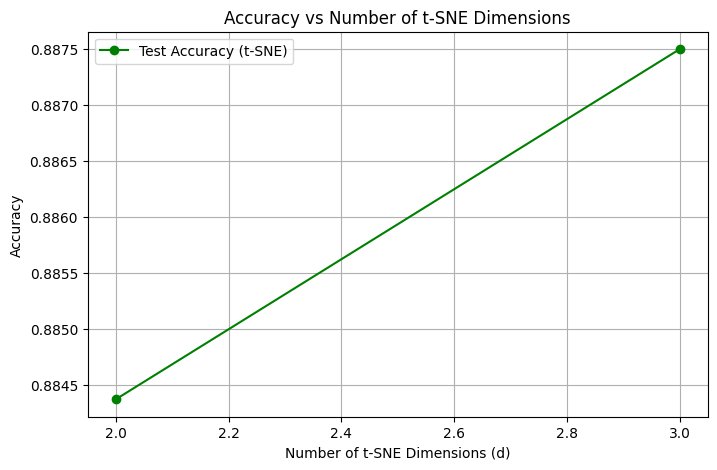

In [13]:
from sklearn.manifold import TSNE

# t-SNE is computationally expensive and often used for visualization (2D/3D).
# Standard sklearn TSNE does not support 'transform' for new data, so we combine train+test for embedding
# and then split them back to calculate pseudo-test accuracy for comparison purposes.

dims_tsne = range(2, 4) # Restricting to 2-3 dimensions as t-SNE is mainly for low-dim visualization
tsne_test_acc = []

X_combined = np.vstack([X_train_scaled, X_test_scaled])
train_size = X_train_scaled.shape[0]

for d in dims_tsne:
    tsne = TSNE(n_components=d, random_state=42, perplexity=30)
    X_combined_tsne = tsne.fit_transform(X_combined)
    
    X_train_tsne = X_combined_tsne[:train_size]
    X_test_tsne = X_combined_tsne[train_size:]
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_tsne, y_train)
    acc = knn.score(X_test_tsne, y_test)
    tsne_test_acc.append(acc)

plt.figure(figsize=(8,5))
plt.plot(dims_tsne, tsne_test_acc, marker='o', color='green', label="Test Accuracy (t-SNE)")
plt.xlabel("Number of t-SNE Dimensions (d)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of t-SNE Dimensions")
plt.grid(True)
plt.legend()
plt.show()

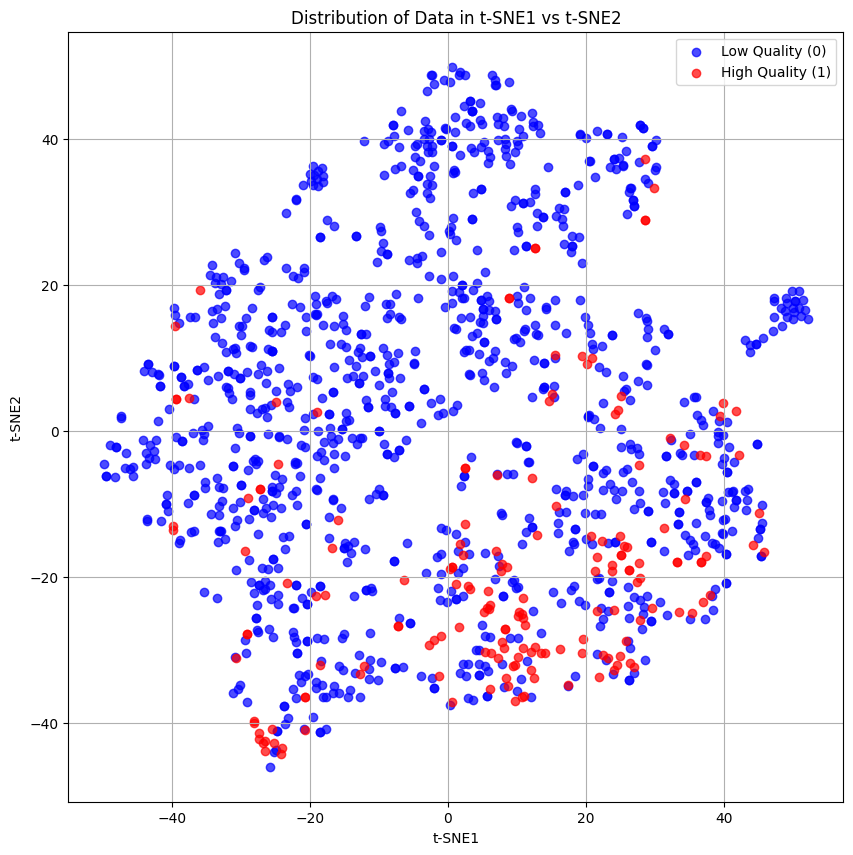

In [14]:
# 2D t-SNE Visualization
# (Using the already computed 2D embedding from the loop if available, or recomputing)
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne_2d = tsne_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10,10))
plt.scatter(
    X_train_tsne_2d[y_train == 0, 0],
    X_train_tsne_2d[y_train == 0, 1],
    label="Low Quality (0)",
    alpha=0.7,
    color="blue"
)

plt.scatter(
    X_train_tsne_2d[y_train == 1, 0],
    X_train_tsne_2d[y_train == 1, 1],
    label="High Quality (1)",
    alpha=0.7,
    color="red"
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("Distribution of Data in t-SNE1 vs t-SNE2")
plt.legend()
plt.grid(True)
plt.show()

## Non-Linear Dimension Reduction (UMAP)

/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


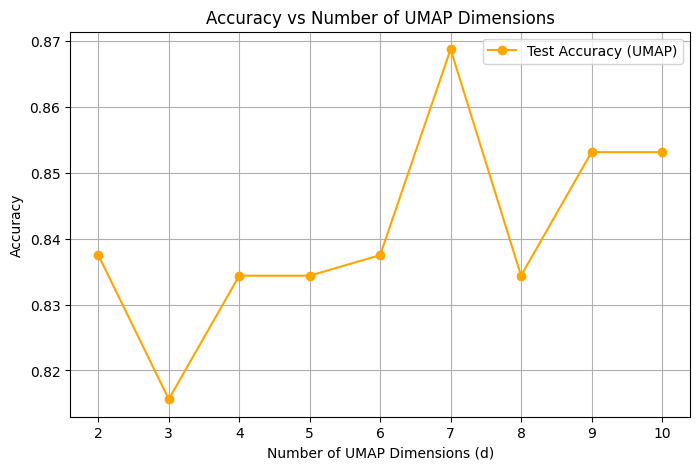

In [15]:
import umap

# Define dimensions to test
dims_umap = range(2, 11)
umap_test_acc = []

for d in dims_umap:
    # UMAP follows the sklearn fit/transform API
    reducer = umap.UMAP(n_components=d, random_state=42)
    reducer.fit(X_train_scaled)
    X_train_umap = reducer.transform(X_train_scaled)
    X_test_umap = reducer.transform(X_test_scaled)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_umap, y_train)
    acc = knn.score(X_test_umap, y_test)
    umap_test_acc.append(acc)

plt.figure(figsize=(8,5))
plt.plot(dims_umap, umap_test_acc, marker='o', color='orange', label="Test Accuracy (UMAP)")
plt.xlabel("Number of UMAP Dimensions (d)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of UMAP Dimensions")
plt.grid(True)
plt.legend()
plt.show()

/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


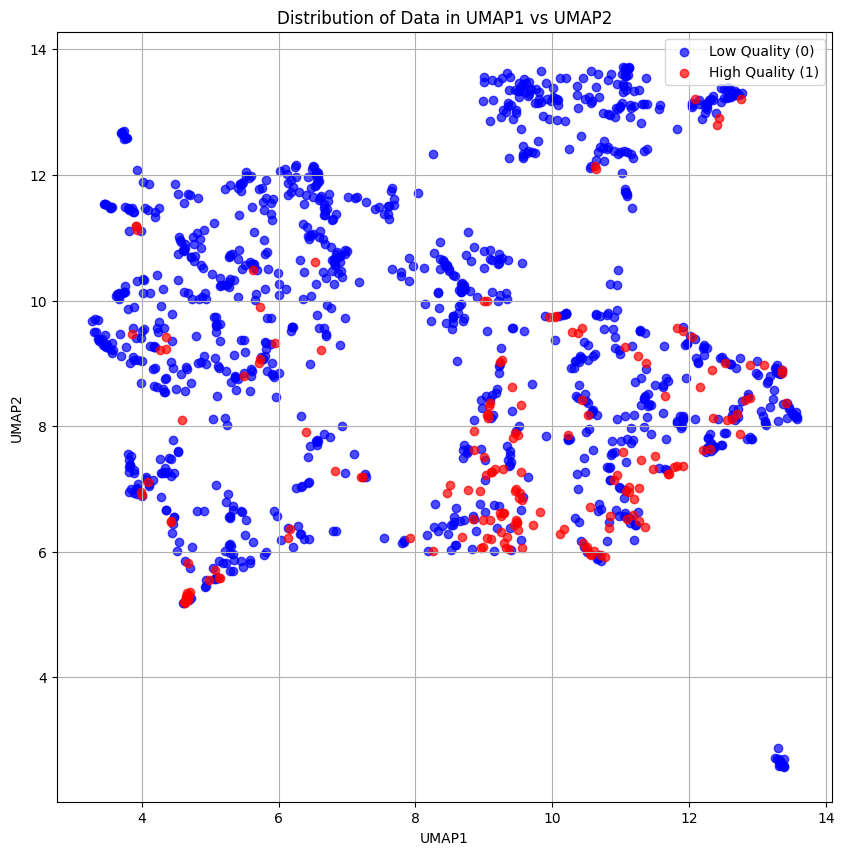

In [16]:
# 2D UMAP Visualization
reducer_2d = umap.UMAP(n_components=2, random_state=42)
X_train_umap_2d = reducer_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10,10))
plt.scatter(
    X_train_umap_2d[y_train == 0, 0],
    X_train_umap_2d[y_train == 0, 1],
    label="Low Quality (0)",
    alpha=0.7,
    color="blue"
)

plt.scatter(
    X_train_umap_2d[y_train == 1, 0],
    X_train_umap_2d[y_train == 1, 1],
    label="High Quality (1)",
    alpha=0.7,
    color="red"
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Distribution of Data in UMAP1 vs UMAP2")
plt.legend()
plt.grid(True)
plt.show()

### Overall Comparison

**To-Do:**
- Compare all three non-linear methods (Isomap, t-SNE, UMAP) against PCA.
- Which method provided the best visualization (clearest separation of classes)?
- Which method achieved the highest accuracy in lower dimensions?
- Discuss computational efficiency (which one was fastest/slowest?).

## 3D Visualizations (Interactive)
To better visualize the clustering and structure, we project the data into 3D space using Isomap, t-SNE, and UMAP. We use Plotly for interactive visualizations.

In [17]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
from sklearn.manifold import Isomap, TSNE
import umap

# Set the default renderer to 'notebook' which is compatible with local Jupyter/VS Code environments
# If this fails, try 'iframe' or 'browser'
pio.renderers.default = 'notebook'

def plot_3d_interactive(X_3d, y, title):
    # Create a DataFrame for Plotly
    df_3d = pd.DataFrame(X_3d, columns=['Component 1', 'Component 2', 'Component 3'])
    df_3d['Quality'] = pd.Series(y).map({0: 'Low Quality (0)', 1: 'High Quality (1)'})
    
    fig = px.scatter_3d(
        df_3d,
        x='Component 1',
        y='Component 2',
        z='Component 3',
        color='Quality',
        color_discrete_map={'Low Quality (0)': 'blue', 'High Quality (1)': 'red'},
        title=title,
        opacity=0.6,
        width=900,
        height=600
    )
    
    # Update markers to be smaller
    fig.update_traces(marker=dict(size=3))
    fig.show()


In [18]:
# 1. Isomap 3D
iso_3d = Isomap(n_components=3)
X_train_iso_3d = iso_3d.fit_transform(X_train_scaled)
plot_3d_interactive(X_train_iso_3d, y_train, "3D Isomap Distribution (Interactive)")

In [19]:
# 2. t-SNE 3D
# Note: t-SNE is slower, so we compute it once here.
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_train_tsne_3d = tsne_3d.fit_transform(X_train_scaled)
plot_3d_interactive(X_train_tsne_3d, y_train, "3D t-SNE Distribution (Interactive)")

In [20]:
# 3. UMAP 3D
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_train_umap_3d = umap_3d.fit_transform(X_train_scaled)
plot_3d_interactive(X_train_umap_3d, y_train, "3D UMAP Distribution (Interactive)")

/Users/sebastianmendoza/Downloads/SYDE 572/Programming/programming 5/uncorking-wine-quality/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

